In [1]:
import warnings
from argparse import ArgumentParser

import pandas as pd

from datasets import Priv_NAMES as DATASET_NAMES
from datasets import get_private_dataset
from models import get_all_models
from models import get_model
from utils.Server import train
from utils.Toolbox_analysis import create_latent_df, process_latent_df

warnings.simplefilter(action='ignore', category=FutureWarning)


def parse_args():
    parser = ArgumentParser(description='You Only Need Me', allow_abbrev=False)
    parser.add_argument('--device_id', type=int, default=0, help='The Device Id for Experiment')

    # Communication - epochs
    parser.add_argument('--communication_epoch', type=int, default=15,
                        help='The Communication Epoch in Federated Learning')
    parser.add_argument('--local_epoch', type=int, default=3, help='The Local Epoch for each Participant')

    # Participants info
    #TODO: LINK NUMBER OF PARTICIPANTS WITH SIMULATION
    parser.add_argument('--parti_num', type=int, default=None, help='The Number for Participants. If "None" will be setted as the sum of values described in --domain')
    parser.add_argument('--online_ratio', type=float, default=1, help='The Ratio for Online Clients')

    # Data parameters
    parser.add_argument('--dataset', type=str, default='fl_leaks', choices=DATASET_NAMES, help='Which scenario to perform experiments on.')
    parser.add_argument('--experiment_id', type=str, default='TEST_WINDOW_2', help='Which scenario the experiment is for.')
    parser.add_argument('--domains', type=dict, default={
                                                        'Graeme': 5,
                                                        # 'Balerma': 3,
                                                        },
                        help='Domains and respective number of participants.')

    ## Time series preprocessing
    parser.add_argument('--interval_agg', type=int, default=2 * 60 ** 2,
                        help='Agregation interval (seconds) of time series')
    parser.add_argument('--window_size', type=int, default=300, help='Rolling window length')

    # Model (AER) parameters
    parser.add_argument('--input_size', type=int, default=5, help='Number of sensors')  #TODO adaptar
    parser.add_argument('--output_size', type=int, default=5, help='Shape output - dense layer')
    parser.add_argument('--lstm_units', type=int, default=30,
                        help='Number of LSTM units (the latent space will have dimension 2 times bigger')

    # Federated parameters
    parser.add_argument('--model', type=str, default='fedavg', help='Federated Model name.', choices=get_all_models()) #fedavg

    parser.add_argument('--structure', type=str, default='homogeneity')

    parser.add_argument('--pri_aug', type=str, default='weak',  # weak strong
                        help='Augmentation for Private Data')
    parser.add_argument('--learning_decay', type=bool, default=False, help='The Option for Learning Rate Decay')
    parser.add_argument('--averaging', type=str, default='weight', help='The Option for averaging strategy')

    parser.add_argument('--infoNCET', type=float, default=0.02, help='The InfoNCE temperature')
    parser.add_argument('--T', type=float, default=0.05, help='The Knowledge distillation temperature')
    parser.add_argument('--weight', type=int, default=1, help='The Weigth for the distillation loss')

    # torch.set_num_threads(4)
    # def add_management_args(parser: ArgumentParser) -> None:
    #     parser.add_argument('--csv_log', action='store_true',
    #                         help='Enable csv logging',default=False)
    #
    # add_management_args(parser)
    #
    args, unknown = parser.parse_known_args()

    if args.parti_num is None:
        args.parti_num = sum(args.domains.values())
    #
    # best = best_args[args.dataset][args.model]
    #
    # for key, value in best.items():
    #     setattr(args, key, value)
    #
    # if args.seed is not None:
    #     set_random_seed(args.seed)

    return args

In [ ]:
args = parse_args()

results = {}

for scenario in ['Baseline', 'AutoScenario_1']:

    results[scenario] = {}

    priv_dataset = get_private_dataset(args)

    backbones_list = priv_dataset.get_backbone(parti_num=args.parti_num,
                                               names_list=None,
                                               n_series=args.input_size)

    model = get_model(backbones_list, args, priv_dataset)

    # priv_dataset.EXP_ID = ['Drift_PIPELINE_ALERNATIVE']
    # priv_dataset.DOMAINS_LIST = ['Balerma']

    priv_train_loaders, aux_latent = train(model=model,
                                           private_dataset=priv_dataset,
                                           scenario=scenario,
                                           args=args)

    results[scenario]['dl'] = priv_train_loaders
    results[scenario]['lat'] = aux_latent
    results[scenario]['model'] = model

Training client 1
Epoch 1/3 - Loss: 9.9931
Epoch 2/3 - Loss: 8.6391
Epoch 3/3 - Loss: 7.6183
epochs: 3 / total 3
Training client 2
Epoch 1/3 - Loss: 9.7547
Epoch 2/3 - Loss: 8.5542
Epoch 3/3 - Loss: 7.6773
epochs: 3 / total 3
Training client 0
Epoch 1/3 - Loss: 6.2782
Epoch 2/3 - Loss: 5.6182
Epoch 3/3 - Loss: 4.9827
epochs: 3 / total 3
Training client 3
Epoch 1/3 - Loss: 10.6970
Epoch 2/3 - Loss: 9.1915
Epoch 3/3 - Loss: 8.0877
epochs: 3 / total 3
Training client 4
Epoch 1/3 - Loss: 9.9133
Epoch 2/3 - Loss: 8.6960
Epoch 3/3 - Loss: 7.7673
epochs: 3 / total 3
**--**--**--**--**--**--**--**--**--**--
SEM AGREGAÇÃO
Acc: 0.9347	Prec: 0.0000	Rec: 0.0000	F1: 0.0000
Acc: 0.9800	Prec: 0.0000	Rec: 0.0000	F1: 0.0000
Acc: 0.9548	Prec: 0.0000	Rec: 0.0000	F1: 0.0000
Acc: 0.9599	Prec: 0.0000	Rec: 0.0000	F1: 0.0000
Acc: 0.9599	Prec: 0.0000	Rec: 0.0000	F1: 0.0000
Training client 0
Epoch 1/3 - Loss: 6.1383
Epoch 2/3 - Loss: 5.7700
Epoch 3/3 - Loss: 5.2094
epochs: 3 / total 6
Training client 4
Epoch 1/

0


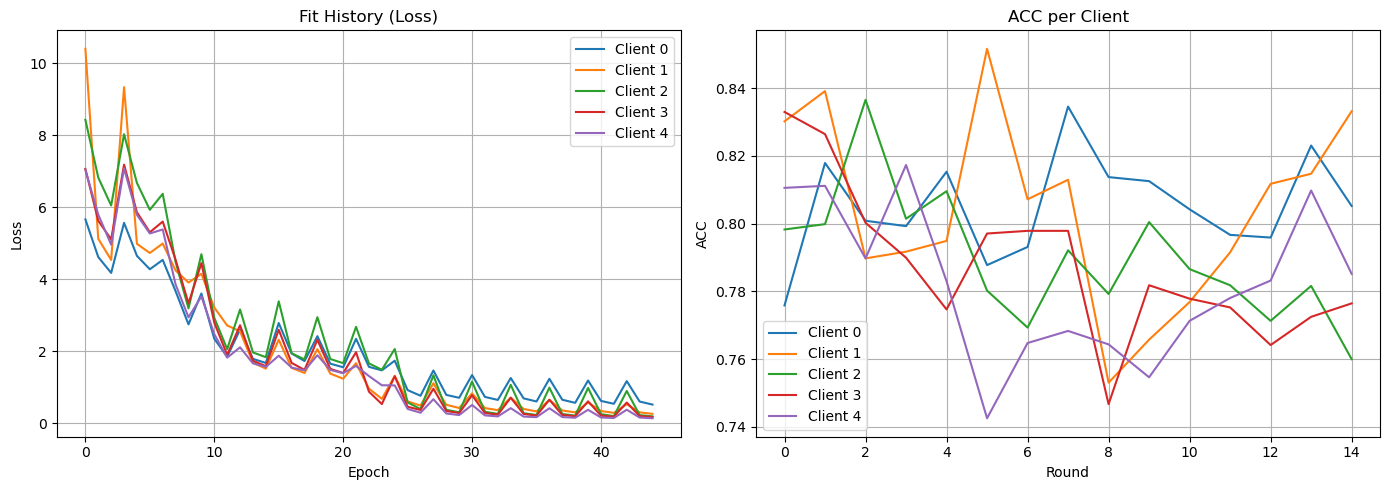

In [3]:
from utils.Toolbox_analysis import plot_all_clients_side_by_side

plot_all_clients_side_by_side(model, priv_train_loaders, metric='acc')

In [4]:
# label_clients = ['District_A', 'District_B', 'District_C', 'District_D', 'District_E']
# label_clients = ['District_A', 'District_B', 'District_C']
label_clients = ['District_A', 'District_B', 'District_C', 'District_D', 'District_E',
                 'District_2A', 'District_2B', 'District_2C']

base_index = results['Baseline']['dl'][0]['X_index']

latent_dfs = {}
for scenario, case in results.items():
    latent_dfs[scenario] = {}
    for epoch, space in enumerate(case['lat']):
        aux_latents = []
        for i, client in enumerate(space):
            baseline_lat = create_latent_df(X_index=base_index,
                                            x_lat=client,
                                            label=scenario + '__' + label_clients[i] + '__' + str(epoch),
                                            is_unix=True)

            aux_latents.append(baseline_lat)

        df_latent = pd.concat(aux_latents)

        df_latent, df_pca_raw, df_umap_raw, df_pca_scaled, df_umap_scaled = process_latent_df(df_latent, umap_neighbors=50, umap_min_dist=0.95)

        latent_dfs[scenario][epoch] = {}
        latent_dfs[scenario][epoch]['latent_space'] = df_latent
        latent_dfs[scenario][epoch]['pca_raw'] = df_pca_raw
        latent_dfs[scenario][epoch]['pca_scl'] = df_pca_scaled
        latent_dfs[scenario][epoch]['umap_raw'] = df_umap_raw
        latent_dfs[scenario][epoch]['umap_scl'] = df_umap_scaled

C:\Users\arthu\anaconda3\envs\TsLeaks\lib\site-packages\sklearn\manifold\_spectral_embedding.py:455: UserWarning: Exited at iteration 382 with accuracies 
[1.90620354e-14 1.45291467e-06 5.34274571e-07 4.01787158e-07]
not reaching the requested tolerance 5.960464477539062e-07.
Use iteration 382 instead with accuracy 
5.972441053663864e-07.

  _, diffusion_map = lobpcg(
C:\Users\arthu\anaconda3\envs\TsLeaks\lib\site-packages\sklearn\manifold\_spectral_embedding.py:455: UserWarning: Exited postprocessing with accuracies 
[1.33165870e-14 1.45291466e-06 5.34274629e-07 4.01787155e-07]
not reaching the requested tolerance 5.960464477539062e-07.
  _, diffusion_map = lobpcg(
C:\Users\arthu\anaconda3\envs\TsLeaks\lib\site-packages\sklearn\manifold\_spectral_embedding.py:455: UserWarning: Exited at iteration 2000 with accuracies 
[4.38794474e-15 8.17377107e-09 3.79604034e-08 3.86903128e-06]
not reaching the requested tolerance 6.705522537231445e-07.
Use iteration 843 instead with accuracy 
6.0117

In [5]:
import pickle

with open('results/exp_latente_results_graeme_2_300.pkl', 'wb') as file:
    pickle.dump(results, file)

with open('results/exp_latente_df_graeme_2_300.pkl', 'wb') as file:
    pickle.dump(latent_dfs, file)

In [ ]:
PARO

In [ ]:
# aux_latent[EPOCH][CLIENT]
aux_latent[0][0].shape

In [ ]:
def create_latent_df(X_index, x_lat, label='Teste', is_unix=False):
    """
    Create a DataFrame with timestamps, latent vector components, and anomaly labels.

    Parameters:
    - X_index: array of shape (n_samples,), can be UNIX timestamps or datetime
    - x_lat: array of shape (n_samples, n_latent_dims)
    - anomaly_df: DataFrame with 'start' and 'end' columns for anomaly intervals
    - is_unix: bool, if True converts X_index from UNIX timestamp to datetime

    Returns:
    - DataFrame with 'timestamp', 'label', and x_0 to x_n columns
    """
    # Step 1: Convert timestamps if needed
    if is_unix:
        timestamps = pd.to_datetime(X_index, unit='s')
    else:
        timestamps = pd.to_datetime(X_index)  # ensures consistent datetime dtype

    # Step 2: Create column names for latent dimensions
    latent_dim_names = [f'x_{i}' for i in range(x_lat.shape[1])]

    # Step 3: Create DataFrame
    df = pd.DataFrame(x_lat, columns=latent_dim_names)
    df['timestamp'] = timestamps
    df['label'] = label

    # Step 5: Reorder columns
    df = df[['timestamp', 'label'] + latent_dim_names]

    return df

In [ ]:
results['Drift_PIPELINE_LOW'] = {}

results['Drift_PIPELINE_LOW']['Baseline'] = (priv_train_loaders, aux_latent[-1], model)

In [ ]:
# >> PARA CADA SEGMENTO
## >>>> UTILIZAR MODELO DO SEGMENTO INICIAL PARA LEVAR TODOS NO MESMO ESPAÇO
import pandas as pd

nets_list_base = model.nets_list

latent_dfs = []
for j, (segment, case) in enumerate(results.items()):
    # label_clients = ['District_A', 'District_B', 'District_C', 'District_D', 'District_E']
    # label_clients = ['District_A', 'District_B', 'District_C']
    label_clients = ['District_A', 'District_B', 'District_C', 'District_D', 'District_E',
                     'District_2A', 'District_2B', 'District_2C']
    aux_latents = []

    for i, client in enumerate(label_clients):
        _, _, _, x_lat = nets_list_base[0].predict(case['Baseline'][0][i]['X'])

        baseline_lat = create_latent_df(X_index=case['Baseline'][0][i]['X_index'],
                                        x_lat=x_lat,
                                        label=segment + '_' + client,
                                        is_unix=True)

        aux_latents.append(baseline_lat)

    df_latent = pd.concat(aux_latents)
    df_latent['timestamp'] += pd.Timedelta(days=30 * j)
    latent_dfs.append(df_latent)

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from sklearn.decomposition import PCA
import umap.umap_ as umap


def reduce_dims(X, method = None, n_components=2, umap_neighbors=15, umap_min_dist=0.1):
    """
    Applies PCA and UMAP to the input data.

    Parameters:
    - X: array-like of shape (n_samples, n_features)
    - n_components: int, number of dimensions for the projection
    - umap_neighbors: int, UMAP neighbors
    - umap_min_dist: float, UMAP min_dist

    Returns:
    - X_pca: PCA-reduced data
    - X_umap: UMAP-reduced data
    """

    pca = PCA(n_components=n_components)

    X_pca = pca.fit_transform(X)
    if method == 'PCA':
        return X_pca, None

    reducer = umap.UMAP(n_components=n_components, n_neighbors=umap_neighbors, min_dist=umap_min_dist)
    X_umap = reducer.fit_transform(X)
    if method == 'UMAP':
        return None, X_umap

    return X_pca, X_umap


def plot_reduced_method(X_pca, X_umap, labels=None, method='PCA', ax=None, title=None):
    """
    Plots reduced data based on the selected method (PCA or UMAP).
    Accepts external axis (ax) for subplot usage.
    """
    if method not in ['PCA', 'UMAP']:
        raise ValueError("Invalid method! Use 'PCA' or 'UMAP'.")

    internal_fig = False
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 5))
        internal_fig = True
    else:
        fig = ax.figure

    # Setup
    if labels is not None:
        labels = np.array(labels)
        unique_labels = np.unique(labels)
        colors = plt.cm.Set1(np.linspace(0, 1, len(unique_labels)))
        label_color_map = {label: color for label, color in zip(unique_labels, colors)}

        for label in unique_labels:
            idx = labels == label
            if method == 'PCA':
                ax.scatter(X_pca[idx, 0], X_pca[idx, 1], c=[label_color_map[label]], label=f"{label}", s=10)
            else:
                ax.scatter(X_umap[idx, 0], X_umap[idx, 1], c=[label_color_map[label]], label=f"{label}", s=10)

        legend_elements = [Patch(facecolor=label_color_map[label], label=f'{label}') for label in unique_labels]
        ax.legend(handles=legend_elements, bbox_to_anchor=(1, 1))
    else:
        proj = X_pca if method == 'PCA' else X_umap
        ax.scatter(proj[:, 0], proj[:, 1], s=10)

    ax.set_title(title if title else f"{method} Projection")
    ax.axis("off")

    if internal_fig:
        plt.tight_layout()
        plt.show()

In [ ]:
df_latent = pd.concat(latent_dfs)
df_latent['week'] = df_latent['timestamp'].dt.to_period('W').astype(str)
df_latent['hour'] = df_latent['timestamp'].dt.hour

# Dimensionality reduction
X_pca, X_umap = reduce_dims(
    X=df_latent.iloc[:, 2:-2],  # adjust index if needed
    method='UMAP',
    n_components=2,
    umap_neighbors=50,
    umap_min_dist=.75
)

In [ ]:
import ipywidgets as widgets
from IPython.display import clear_output

hour_options = sorted(df_latent['hour'].unique())

hour_selector = widgets.SelectMultiple(
    options=hour_options,
    value=[hour_options[0]],
    description='Hour(s):',
    # layout=widgets.Layout(width='50%')
)

# Create the dropdown and slider widgets
method_dropdown = widgets.Dropdown(
    options=['UMAP', 'PCA'],
    value='UMAP',
    description='Method:'
)

# Get available weeks from your timestamp column
available_weeks = sorted(df_latent['week'].unique())

week_slider = widgets.SelectionSlider(
    options=available_weeks,
    value=available_weeks[0],
    description='Week:',
    continuous_update=False,
    # layout=widgets.Layout(width='80%')
)


def update_plot(method, week, hours):
    clear_output(wait=True)

    # Filter by week and selected hours
    df_filtered = df_latent.reset_index(drop=True)
    df_filtered = df_filtered[(df_filtered['week'] == week) & (df_filtered['hour'].isin(hours))]

    print(df_filtered.shape)
    if df_filtered.empty:
        print("No data for selected filters.")
        return

    fig, ax = plt.subplots(figsize=(4, 3))  # Change width and height as desired

    # Plot
    plot_reduced_method(
        X_umap[df_filtered.index, :], X_umap[df_filtered.index, :],
        method=method,
        labels=df_filtered['label'],
        ax=ax
    )


widgets.interact(update_plot, method=method_dropdown, week=week_slider, hours=hour_selector)

In [ ]:
import pandas as pd

# Suppose X_umap and X_pca are available
# Add coordinates to df_latent
df_latent['umap_x'] = X_umap[:, 0]
df_latent['umap_y'] = X_umap[:, 1]


import altair as alt

# Create a selection for hour and week
hour_selection = alt.selection_multi(fields=['hour'], name="Select")
week_selection = alt.selection_single(fields=['week'], name="Week", bind='legend')

# Dropdown for method (UMAP/PCA)
method_dropdown = alt.selection_point(options=['UMAP'], name='Method: ')
method_selection = alt.selection_point(fields=['method'], bind=method_dropdown, name='Method')

# Prepare long-form data
df_umap = df_latent[['umap_x', 'umap_y', 'label', 'hour', 'week']].copy()
df_umap['method'] = 'UMAP'
df_umap = df_umap.rename(columns={'umap_x': 'x', 'umap_y': 'y'})


df_long = df_umap



In [ ]:
chart = alt.Chart(df_long).mark_circle(size=60).encode(
    x='x',
    y='y',
    color='label:N',
    tooltip=['label', 'hour', 'week'],
    opacity=alt.condition(hour_selection, alt.value(1), alt.value(0.05))
).add_selection(
    hour_selection,
    week_selection,
    method_selection
).transform_filter(
    hour_selection
).transform_filter(
    week_selection
).transform_filter(
    method_selection
).properties(
    width=500,
    height=400,
    title='Latent Space Visualization'
)

chart
